# Snapchat Political Ads
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the reach (number of views) of an ad.
    * Predict how much was spent on an ad.
    * Predict the target group of an ad. (For example, predict the target gender.)
    * Predict the (type of) organization/advertiser behind an ad.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
For this project, we will be looking at the ads dataset from 2019 and 2020, the same data we used for project03. We will be using regression to predict on the number of Impressions, our target variable, that each ad campaign recieves. Using the R-squared value from both models, we will assess their accuracy. We are using R^2 here because it gives us a good indication of how well our model predicted impressions, and that is primarily what we are concerned with.

### Baseline Model
For the baseline model, we dropped columns, one-hot encoded columns, standardized columns, and manually binarized columns.

DROP: ADID, CreativeURL, StartDate, EndDate, CandidateBallotInformation, Electoral Districts(Excluded), OsType, Targetting Connection Type, Targetting Carrier (ISP), CreativeProperites
* We dropped these columns because they were either all/mostly NaN values or all unique values that would not provide use for the baseline model. Specifically for StartDate and EndDate, we did not use them because the Pipeline does not take in pd.datetime objects. 

ONE-HOT: CurrencyCode, OrganizationName, BillingAddress, PayingAdvertiserName, Gender, CountryCode, Segments, Language
* We one-hot encoded these columns because there were relatively few number of unique values in each column and we could make sense of NaN values
* We also used TruncatedSVD to reduce the dimensions of the one-hot encoded columns due to the fact that some of the one-hot encoded columns may be perfectly correlated; we did not use PCA here because the matrix was too sparse

STANDARDIZED: Spend
* We standardized spend because it is a quantitative feature that would be utilized better by the ML model if it ranged from 0 to 1. We used StdScaler to do this.

BINARY(NaN to 0, non-Nan to 1): Interests, AdvancedDemographics, All Included/Excluded columns (except Electoral Districts(Excluded))
* We made all of the Included/Excluded columns (except Electoral Districts(Excluded)) so we could distinguish between ad campaigns that had some sort of filter in these columns and ad campaigns that did not use a filter for these columns. This would help us see if ANY targetting by Region, Elec. Districts, Radius, Metros, Postal Codes, or Location Categories had an effect on Impression count, our target variable.

Model Used: Decision Tree Regressor

Our model had 22 variables. 1 quantitative, 0 ordinal, and 21 nominal.
It had an R-squared value of 0.4139 on average. This is okay, considering the fact that we did not feature engineer anything yet and a lot of data was based on one-hot encoded columns. 


### Final Model
For our final model, we built upon our baseline model by creating 3 feature engineered columns: days_running, startAge, and endAge; we also used did hyperparameter tuning. We also decided to use the DecisionTreeRegressor

* For days_running, we used the startDate and endDate and found the number of days the campaign was running. If the endDate was null, we considered the ad to be still running and imputed it with the date in which we downloaded the data as this is a consistently updated dataset.

* For startAge and endAge, we took the AgeBracket column and split it into these columns so we could make sense of it and provide our final model with more quantitative features. Also, if the AgeBracket had a value such as '18+' we filled engAge with 75. Through research, we found that 75 is roughly the average life expectancy of any person. We also set the minimum of the startAge column to 10 because we believe no one under the age of 10 is necessarily targetted in Snapchat Ads. So for values such as '17-' or NaN, startAge is 10.

* We then normalized our engineered features

* We also did hyperparameter tuning for the DecisionTreeRegressor and the TruncatedSVD 

* We also looked into LogisticRegression and did hyperparameter tuning for that, but in the end DEcisionTreeRegressor gave us a better accuracy, probably due to the fact that DecisionTreeRegressor is pretty good at generalizing.

These engineered features are good for our data because they provide more quantitative variables for our model. Also, we weren't able to capture the date fields in our baseline model since the Pipeline did not accept datetime objects. Thus, by having days_running, we believe this will provide useful data for the model to predict on number of Impressions, our target variable. Similarly with AgeBracket, we now can optimaize the data found in that column by splitting it in two and creating a definition for values such as '18+' or '17-'. We chose best parameters by looking at max_depth, min_samples_leaf, and min_samples_split for our DecisionTreeRegressor which had the best respective values of 5, 5, and 3. We also looked at what type of algorithm parameter works best for TruncatedSVD, and it turns out 'arpack' performed best with this set of DecisionTreeRegressor parameters. We accomplished this using GridSearchCV. We did not use other hyperparameters because the computation cost was too high.



### Fairness Evaluation
To evaluate our method for fairness we look to the age bracket that the ad was targetting, specifically the feature engineered startAge column. Using this column, we create startAgebracket, binning the column into brackets of 5 years. Our metric is the mean of differences of RMSE of each bracket. We are using this metric as our parity measure because it deals with accuracy (how different our predicted vs. actual values are). If we are to see that the mean of differences of RMSEs of each startAgeBracket be significantly different after running a permutation test, then we know our model is bias because it is making wildly wrong predictions for particular startAgebrackets; thus, we can say that our model is not fair in treating startAgebracket.

We then perform a permutation test. Our null hypothesis is that there is not a significant difference among the means of differences of RMSE of each bracket. Our alternative hypothesis is that there is a significant difference in this metrics. We use a significance value of 0.01.

After running our permutation test, we get a p-value of 0.06. Thus, we reject the null hypothesis and cannot conclude that there is no significant difference among the means of differences of RMSE of each bracket. This leads us to believe that our model is treating each of the values in the startAgebracket fairly.

### Introduction
For this project, we will be looking at the ads dataset from 2019 and 2020, the same data we used for project03. We will be using regression to predict on the number of Impressions, our target variable, that each ad campaign recieves. Using the R-squared value from both models, we will assess their accuracy. We are using R^2 here because it gives us a good indication of how well our model predicted impressions, and that is primarily what we are concerned with.

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
import re
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV


In [3]:
sc_2019 = pd.read_csv('PoliticalAds_2019.csv')
sc_2020 = pd.read_csv('PoliticalAds_2020.csv')

In [4]:
ads = pd.concat([sc_2019, sc_2020], ignore_index = True)

## Imputing and cleaning specific columns 

In [7]:
#Imputing NaN values for differnt columns, so that sklearn does not error when it receives nan values
# these values will just be one hot encoded later on anyways
ads['Segments'] = ads['Segments'].fillna('unspecified') # to be used in one hot encoding
ads['Language'] = ads['Language'].fillna('no lang') # nans mean no language criteria was used according to readme
ads['Gender'] = ads['Gender'].fillna('all genders') #nans mean all genders according to readme

In [8]:
# We want to have uniformity for the spend so coverting each ad spend to USD.
def conversion(x):
    if x == 'USD':
        return 1
    elif x == 'EUR':
        return 1.1
    elif x == 'GBP':
        return 1.24
    elif x == 'CAD':
        return 0.71
    elif x == 'AUD':
        return 0.65
    elif x == 'SEK':
        return 0.1
    elif x == 'NOK':
        return 0.098

In [9]:
ads['Conversion_Ratio'] = ads['Currency Code'].apply(lambda x: conversion(x))
ads['Spend'] = ads['Spend'] * ads['Conversion_Ratio']
ads = ads.drop(['Conversion_Ratio'], axis=1) # drop columns we don't need anymore

## Making certain columns binary (because too many unique values to one hot encode), then pass them through the pipeline

In [10]:
def make_binary(x):
    '''converts features to binary based off if they are null or not '''
    if x != 0:
        x = 1
    return x

In [11]:
# making these columns into binary (1 if not null, 0 if null)
binars = ['Regions (Included)', 'Regions (Excluded)',
       'Electoral Districts (Included)', 
       'Radius Targeting (Included)', 'Radius Targeting (Excluded)',
       'Metros (Included)', 'Metros (Excluded)', 'Postal Codes (Included)',
       'Postal Codes (Excluded)', 'Location Categories (Included)',
       'Location Categories (Excluded)', 'Interests', 'AdvancedDemographics']
for i in binars:
    ads[i] = ads[i].fillna(0).apply(lambda x: make_binary(x))

## Feature Engineering

## Using StartDate and EndDate to created days_running column

In [12]:
def convert_to_days(x):
    '''converts datetime object to days, rounds up to the next highest day if a single second of the current day elapses'''
    days = x.days
    seconds = x.seconds
    if seconds > 0:
        return int(days + 1)
    return days

In [13]:
# The Z in the StartDate and EndDate columns stand for zero timezone, and is offset by 0 from the 
# coordinated universal time

#cleaning StartDate and EndDate, strip the z then convert to datetime
ads['StartDate'] = pd.to_datetime(ads['StartDate'].str.strip('Z'), format="%Y-%m-%dT%H:%M:%S")
ads['StartDate']  = ads['StartDate'].astype('datetime64[ns]')
ads['EndDate'] = pd.to_datetime(ads['EndDate'].str.strip('Z'), format="%Y-%m-%dT%H:%M:%S")
ads['EndDate']  = ads['EndDate'].astype('datetime64[ns]')

# remove rows that have a startDate that comes before EndDate because that makes no sense and creates
# questions of faithfulness about these rows
negative_days = ads[ads['StartDate'] > ads['EndDate']]
print('there are ' + str(negative_days.shape[0]) + " rows with faulty start and end dates")
print(ads.shape) # old shape
ads = ads.drop(negative_days.index, axis = 0)
print(ads.shape) # new shape

there are 37 rows with faulty start and end dates
(5411, 34)
(5374, 34)


In [14]:
# add number of days adds is running
# leave null values for endDate as is because do not want to assume null means the ad is still running
exceed_curr_date = ads[ads['EndDate'] > pd.to_datetime('2020-05-11 00:00:00')]
print("There are currently " + str(exceed_curr_date.shape[0]) + " ads that are for sure running right now")
ads.loc[exceed_curr_date.index, 'EndDate'] = pd.to_datetime('2020-05-11 00:00:00')

# compute number of days ad is running, if end date is null, impute the null value with may 9, 2020

ads['EndDate'] = ads['EndDate'].fillna(pd.to_datetime('2020-05-11 00:00:00'))

# dtype will be int, converted datetime object to days, rounding up to next day to avoid instance where
# 0 days may occur 
ads['days_running'] = (ads['EndDate'] - ads['StartDate'])
ads['days_running'] = ads['days_running'].apply(lambda x: convert_to_days(x))

There are currently 287 ads that are for sure running right now


## Dealing with Age Bracket - split it into start age and end age (if no end age specified, take average death age of the world which is 75

In [15]:
def start_age(x):
    start = '^[0-9]{2}' # regex
    if len(x) < 5 and x[2] == '-':
        return 10
    else:
        return re.search(start, x).group()

In [16]:
def end_age(x):
    end = '[0-9]{2}$'
    if len(x) < 5:
        if x[2] == '+':
            return 75 # average death age of the world
        elif x[2] == '-':
            return x[:2]
    else:
        return re.search(end, x).group()

In [55]:
# creating columns startAge and endAge
ads['startAge'] = ads['AgeBracket'].fillna('10-75').apply(lambda x: start_age(x))
ads['endAge'] = ads['AgeBracket'].fillna('10-75').apply(lambda x: end_age(x))
ads['startAge'] = ads['startAge'].astype(int)
ads['startAge'] = ads['startAge'].astype(int)

### Baseline Model
For the baseline model, we dropped columns, one-hot encoded columns, standardized columns, and manually binarized columns.

DROP: ADID, CreativeURL, StartDate, EndDate, CandidateBallotInformation, Electoral Districts(Excluded), OsType, Targetting Connection Type, Targetting Carrier (ISP), CreativeProperites
* We dropped these columns because they were either all/mostly NaN values or all unique values that would not provide use for the baseline model. Specifically for StartDate and EndDate, we did not use them because the Pipeline does not take in pd.datetime objects. 

ONE-HOT: CurrencyCode, OrganizationName, BillingAddress, PayingAdvertiserName, Gender, CountryCode, Segments, Language
* We one-hot encoded these columns because there were relatively few number of unique values in each column and we could make sense of NaN values
* We also used TruncatedSVD to reduce the dimensions of the one-hot encoded columns due to the fact that some of the one-hot encoded columns may be perfectly correlated; we did not use PCA here because the matrix was too sparse

STANDARDIZED: Spend
* We standardized spend because it is a quantitative feature that would be utilized better by the ML model if it ranged from 0 to 1. We used StdScaler to do this.

BINARY(NaN to 0, non-Nan to 1): Interests, AdvancedDemographics, All Included/Excluded columns (except Electoral Districts(Excluded))
* We made all of the Included/Excluded columns (except Electoral Districts(Excluded)) so we could distinguish between ad campaigns that had some sort of filter in these columns and ad campaigns that did not use a filter for these columns. This would help us see if ANY targetting by Region, Elec. Districts, Radius, Metros, Postal Codes, or Location Categories had an effect on Impression count, our target variable.

Model Used: Decision Tree Regressor

Our model had 22 variables. 1 quantitative, 0 ordinal, and 21 nominal.
It had an R-squared value of 0.4139 on average (See final model section for code on computing average R^2 value). This is okay, considering the fact that we did not feature engineer anything yet and a lot of data was based on one-hot encoded columns. 


In [56]:
X = ads.drop(['CreativeUrl','StartDate','EndDate','CandidateBallotInformation','Electoral Districts (Excluded)',
            'Targeting Carrier (ISP)', 'ADID','Targeting Connection Type', 'Impressions', 'OsType', 'AgeBracket'], axis = 1)
y = ads['Impressions']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [19]:
#baseline model - contains no hyperparameter tuning or featured engineers
ohe_cols = ['CountryCode',
            'Segments',
            'Language',
            'OrganizationName',
            'Currency Code',
            'PayingAdvertiserName',
            'BillingAddress',
            'Gender']
# perform one hot encoding
ohe_transformer = Pipeline(steps = [('ohe', OneHotEncoder(handle_unknown = 'ignore')),
                                     ('tSVD', TruncatedSVD())
                                   ])

normalize_cols = ['Spend']
# perform normalization
normalize_transformer = Pipeline(steps = [('scaler', StandardScaler()) # perform normalization for quant. cols
                            ])

passthrough_cols = ['Interests',
                   'AdvancedDemographics',
                   'Regions (Excluded)',
                   'Regions (Included)',
                   'Electoral Districts (Included)',
                   'Radius Targeting (Included)',
                   'Radius Targeting (Excluded)',
                   'Metros (Included)',
                   'Metros (Excluded)',
                   'Postal Codes (Included)',
                   'Postal Codes (Excluded)',
                   'Location Categories (Included)',
                   'Location Categories (Excluded)']

# passthrough these columns into the model
passthrough_transfomer = Pipeline(steps=[
        ("func-pass-through", FunctionTransformer(lambda x: x, validate = False))
    ])
# putting it all together using columntransformer
preproc = ColumnTransformer(transformers=[('ohe', ohe_transformer, ohe_cols),
                                          ('passthrough', passthrough_transfomer, passthrough_cols),
                                          ('scaler', normalize_transformer, normalize_cols)
                                         ])
# putting the preprocessing and the model into a single pipeline
baseline_pipe = Pipeline([('preprocessing', preproc), ('dtr', DecisionTreeRegressor())])

## Improved Model - contains engineered features

In [20]:
# improved model with featured engineers- will be used for hyperparameter tuning
ohe_cols = ['CountryCode',
            'Segments',
            'Language',
            'OrganizationName',
            'Currency Code',
            'PayingAdvertiserName',
            'BillingAddress',
            'Gender']
# perform one hot encoding
# TruncatedSVD to reduce dimensions
ohe_transformer = Pipeline(steps = [('ohe', OneHotEncoder(handle_unknown = 'ignore')), # return sparse matrix
                                     ('tSVD', TruncatedSVD()) 
                                   ])

normalize_cols = ['Spend', 'days_running', 'startAge','endAge'] # normalize the engineered quant. features
normalize_transformer = Pipeline(steps = [('scaler', StandardScaler()) # perform normalization for quant. cols
                            ])

passthrough_cols = ['Interests',
                   'AdvancedDemographics',
                   'Regions (Excluded)',
                   'Regions (Included)',
                   'Electoral Districts (Included)',
                   'Radius Targeting (Included)',
                   'Radius Targeting (Excluded)',
                   'Metros (Included)',
                   'Metros (Excluded)',
                   'Postal Codes (Included)',
                   'Postal Codes (Excluded)',
                   'Location Categories (Included)',
                   'Location Categories (Excluded)',
                   'startAge',
                   'endAge']

# to be passed through ML model 
passthrough_transfomer = Pipeline(steps=[
        ("func-pass-through", FunctionTransformer(lambda x: x, validate = False))
    ])

# column transformer for preprocessing
preproc = ColumnTransformer(transformers=[('ohe', ohe_transformer, ohe_cols),
                                          ('passthrough', passthrough_transfomer, passthrough_cols),
                                          ('scaler', normalize_transformer, normalize_cols)
                                         ])

# putting preprocessing and model into a single pipeline
improved_pipe = Pipeline([('preprocessing', preproc), 
                       ('dtr', DecisionTreeRegressor())])

### Final Model
For our final model, we built upon our baseline model by creating 3 feature engineered columns: days_running, startAge, and endAge; we also used did hyperparameter tuning. We also decided to use the DecisionTreeRegressor

* For days_running, we used the startDate and endDate and found the number of days the campaign was running. If the endDate was null, we considered the ad to be still running and imputed it with the date in which we downloaded the data as this is a consistently updated dataset.

* For startAge and endAge, we took the AgeBracket column and split it into these columns so we could make sense of it and provide our final model with more quantitative features. Also, if the AgeBracket had a value such as '18+' we filled engAge with 75. Through research, we found that 75 is roughly the average life expectancy of any person. We also set the minimum of the startAge column to 10 because we believe no one under the age of 10 is necessarily targetted in Snapchat Ads. So for values such as '17-' or NaN, startAge is 10. (See work above in feature engineering section for code on how we derived the engineered features.

* We then normalized our engineered features

* We also did hyperparameter tuning for the DecisionTreeRegressor and the TruncatedSVD 

* We also looked into LogisticRegression and did hyperparameter tuning for that, but in the end DEcisionTreeRegressor gave us a better accuracy, probably due to the fact that DecisionTreeRegressor is pretty good at generalization.

These engineered features are good for our data because they provide more quantitative variables for our model. Also, we weren't able to capture the date fields in our baseline model since the Pipeline did not accept datetime objects. Thus, by having days_running, we believe this will provide useful data for the model to predict on number of Impressions, our target variable. Similarly with AgeBracket, we now can optimaize the data found in that column by splitting it in two and creating a definition for values such as '18+' or '17-'. We chose best parameters by looking at max_depth, min_samples_leaf, and min_samples_split for our DecisionTreeRegressor which had the best respective values of 5, 5, and 3. We also looked at what type of algorithm parameter works best for TruncatedSVD, and it turns out 'arpack' performed best with this set of DecisionTreeRegressor parameters. We accomplished this using GridSearchCV. We did not use other hyperparameters because the computation cost was too high.

## Hyperparameter Tuning

In [22]:
parameters = {
    'dtr__max_depth': [2,3,4,5,7,10,13,15,18,None], # DecisionTreeRegressor parameter
    'dtr__min_samples_split':[2,3,5,7,10,15,20], # DecisionTreeRegressor parameter
    'dtr__min_samples_leaf':[2,3,5,7,10,15,20], # DecisionTreeRegressor parameter
    'preprocessing__ohe__tSVD__algorithm': ['randomized','arpack'] # TruncatedSVD parameter  
}

In [23]:
# using improved model to compute hyperparameters to be used for final model
clf = GridSearchCV(improved_pipe, parameters, cv = 5)

In [24]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('ohe',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('ohe',
                                                                                          OneHotEncoder(categorical_features=None,
                                                                                                        categories=None,
           

In [25]:
# find best parameters
best_params = clf.best_params_
best_params

{'dtr__max_depth': 5,
 'dtr__min_samples_leaf': 5,
 'dtr__min_samples_split': 3,
 'preprocessing__ohe__tSVD__algorithm': 'arpack'}

## Final Model

In [26]:
# final model - contains engineered features and hyperparameter tuning
ohe_cols = ['CountryCode',
            'Segments',
            'Language',
            'OrganizationName',
            'Currency Code',
            'PayingAdvertiserName',
            'BillingAddress',
            'Gender']
# perform one hot encoding
# TruncatedSVD to reduce dimensions
ohe_transformer = Pipeline(steps = [('ohe', OneHotEncoder(handle_unknown = 'ignore')), # return sparse matrix
                                     ('tSVD', TruncatedSVD(algorithm = 
                                                           best_params['preprocessing__ohe__tSVD__algorithm'])) 
                                   ])

normalize_cols = ['Spend', 'days_running', 'startAge','endAge'] # normalize the engineered quant. features
normalize_transformer = Pipeline(steps = [('scaler', StandardScaler()) # perform normalization for quant. cols
                            ])

passthrough_cols = ['Interests',
                   'AdvancedDemographics',
                   'Regions (Excluded)',
                   'Regions (Included)',
                   'Electoral Districts (Included)',
                   'Radius Targeting (Included)',
                   'Radius Targeting (Excluded)',
                   'Metros (Included)',
                   'Metros (Excluded)',
                   'Postal Codes (Included)',
                   'Postal Codes (Excluded)',
                   'Location Categories (Included)',
                   'Location Categories (Excluded)',
                   'startAge',
                   'endAge']

# to be passed through ML model 
passthrough_transfomer = Pipeline(steps=[
        ("func-pass-through", FunctionTransformer(lambda x: x, validate = False))
    ])

# column transformer for preprocessing
preproc = ColumnTransformer(transformers=[('ohe', ohe_transformer, ohe_cols),
                                          ('passthrough', passthrough_transfomer, passthrough_cols),
                                          ('scaler', normalize_transformer, normalize_cols)
                                         ])

# putting all the preprocessing and model in a single pipeline
final_pipe = Pipeline([('preprocessing', preproc), 
                       ('dtr', DecisionTreeRegressor(max_depth = best_params['dtr__max_depth'],
                                                    min_samples_leaf = best_params['dtr__min_samples_leaf'],
                                                    min_samples_split = best_params['dtr__min_samples_split']))])

In [27]:
# make arrays to hold r^2 values for respective models
r2_base = []
r2_final = []

#find average r^2 for 100 different training and test sets
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X,y) # use same training and test data
    baseline_pipe.fit(X_train, y_train)
    final_pipe.fit(X_train, y_train)
    r2_base.append(baseline_pipe.score(X_test, y_test)) # calculate r^2 for baseline
    r2_final.append(final_pipe.score(X_test, y_test)) # calculate r^2 for final

print("The average r^2 score for baseline model was: " + str(np.mean(r2_base)))
print("The average r^2 score for final model was: " + str(np.mean(r2_final)))

The average r^2 score for baseline model was: 0.4138509995428252
The average r^2 score for final model was: 0.43208828245200026


### Fairness Evaluation
To evaluate our method for fairness we look to the age bracket that the ad was targetting, specifically the feature engineered startAge column. Using this column, we create startAgebracket, binning the column into brackets of 5 years. Our metric is the mean of differences of RMSE of each bracket. We are using this metric as our parity measure because it deals with accuracy (how different our predicted vs. actual values are). If we are to see that the mean of differences of RMSEs of each startAgeBracket be significantly different after running a permutation test, then we know our model is bias because it is making wildly wrong predictions for particular startAgebrackets; thus, we can say that our model is not fair in treating startAgebracket.

We then perform a permutation test. Our null hypothesis is that there is not a significant difference among the means of differences of RMSE of each bracket. Our alternative hypothesis is that there is a significant difference in this metrics. We use a significance value of 0.01.

After running our permutation test, we get a p-value of 0.06. Thus, we reject the null hypothesis and cannot conclude that there is no significant difference among the means of differences of RMSE of each bracket. This leads us to believe that our model is treating each of the values in the startAgebracket fairly.

#### Null Hypothesis: The mean difference of RMSEs for startAgebrackets are all relatively similar
#### Alternative: The mean difference of RMSEs for startAgebrackets are not simliar to one another
##### **Assume Significance Level of 0.01

In [58]:
# create a dataframe, result, that contains the predicted and actual impressions
result = X_test
result['imp_val'] = y_test
result['predictions'] = clf.predict(X_test)

/Users/peter/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/peter/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
# define a column startAgebracket which bins the startAge to bins 5 years wide
result['startAgebracket'] = result['startAge'].apply(lambda x:5*(x//5))

/Users/peter/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


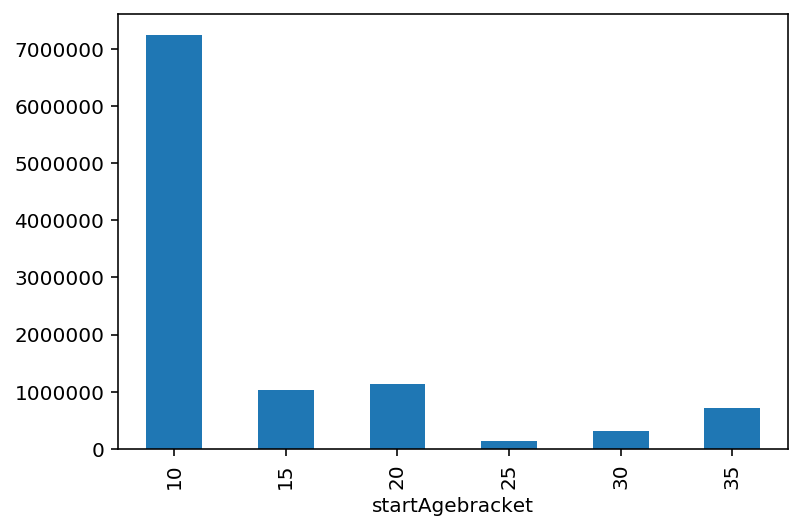

In [60]:
# looking at a bar chart of the RMSEs for the differnt startAgebrackets
(
    result
    .groupby('startAgebracket')
    .apply(lambda x: np.sqrt(np.square(np.subtract(x.imp_val,x.predictions)).mean()))
    .plot(kind='bar')
)

In [64]:
# actual mean difference of RMSEs among the different startAgebrackets
obs = result.groupby('startAgebracket').apply(lambda x: np.sqrt(np.square((x.imp_val - x.predictions)).mean())).diff().iloc[-1]

In [71]:
metrs = []
for _ in range(100):
    # s represents the mean difference of RMSE's among the startAgebrackets, calculate this for each sample
    s = (result[['startAgebracket', 'predictions', 'imp_val']]
         .assign(age=result.startAgebracket.sample(frac=1.0, replace=False).reset_index(drop=True))
         .groupby('age')
         .apply(lambda x: np.sqrt(np.square((x.imp_val - x.predictions)).mean()))
         .diff()
         .mean())
         
    metrs.append((s))

In [72]:
# p-value
print(pd.Series(metrs >= obs).mean())

0.06


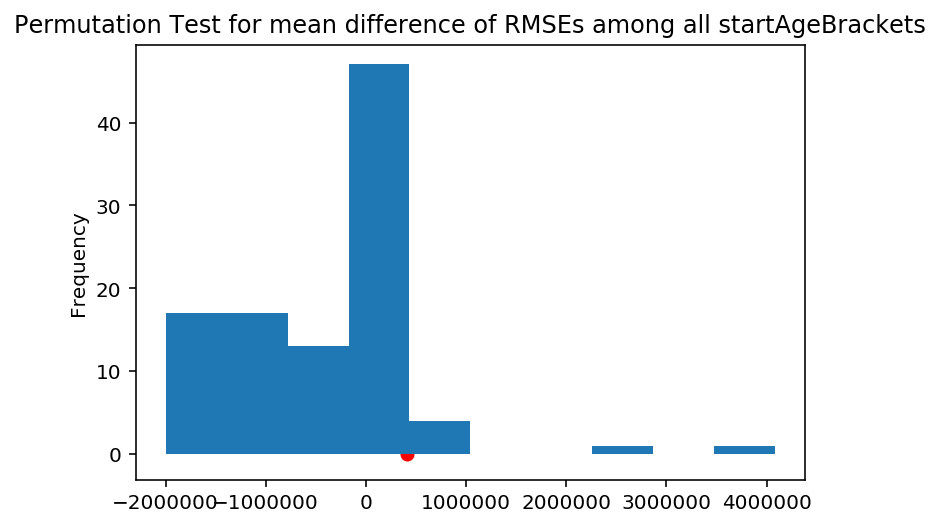

In [74]:
pd.Series(metrs).plot(kind='hist', title='Permutation Test for mean difference of RMSEs among all startAgeBrackets')
plt.scatter(obs, 0, c='r');

### Conclusion: Because we acheived a p-value of 0.06, we fail to reject the null hypothesis, and thus are inclined to believe that the model is treating different startAgebrackets relatively the same